/home/spark-12fec2e7-d9f1-4b3e-a26f-3e/.ipykernel/2487/command-6307054016155225-1997412518:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_rating", y="title", data=top_movies_pd, palette="viridis", ax=axes[0,0])
/home/spark-12fec2e7-d9f1-4b3e-a26f-3e/.ipykernel/2487/command-6307054016155225-1997412518:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="genre", data=genre_count_pd, palette="magma", ax=axes[0,1])
/home/spark-12fec2e7-d9f1-4b3e-a26f-3e/.ipykernel/2487/command-6307054016155225-1997412518:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for th

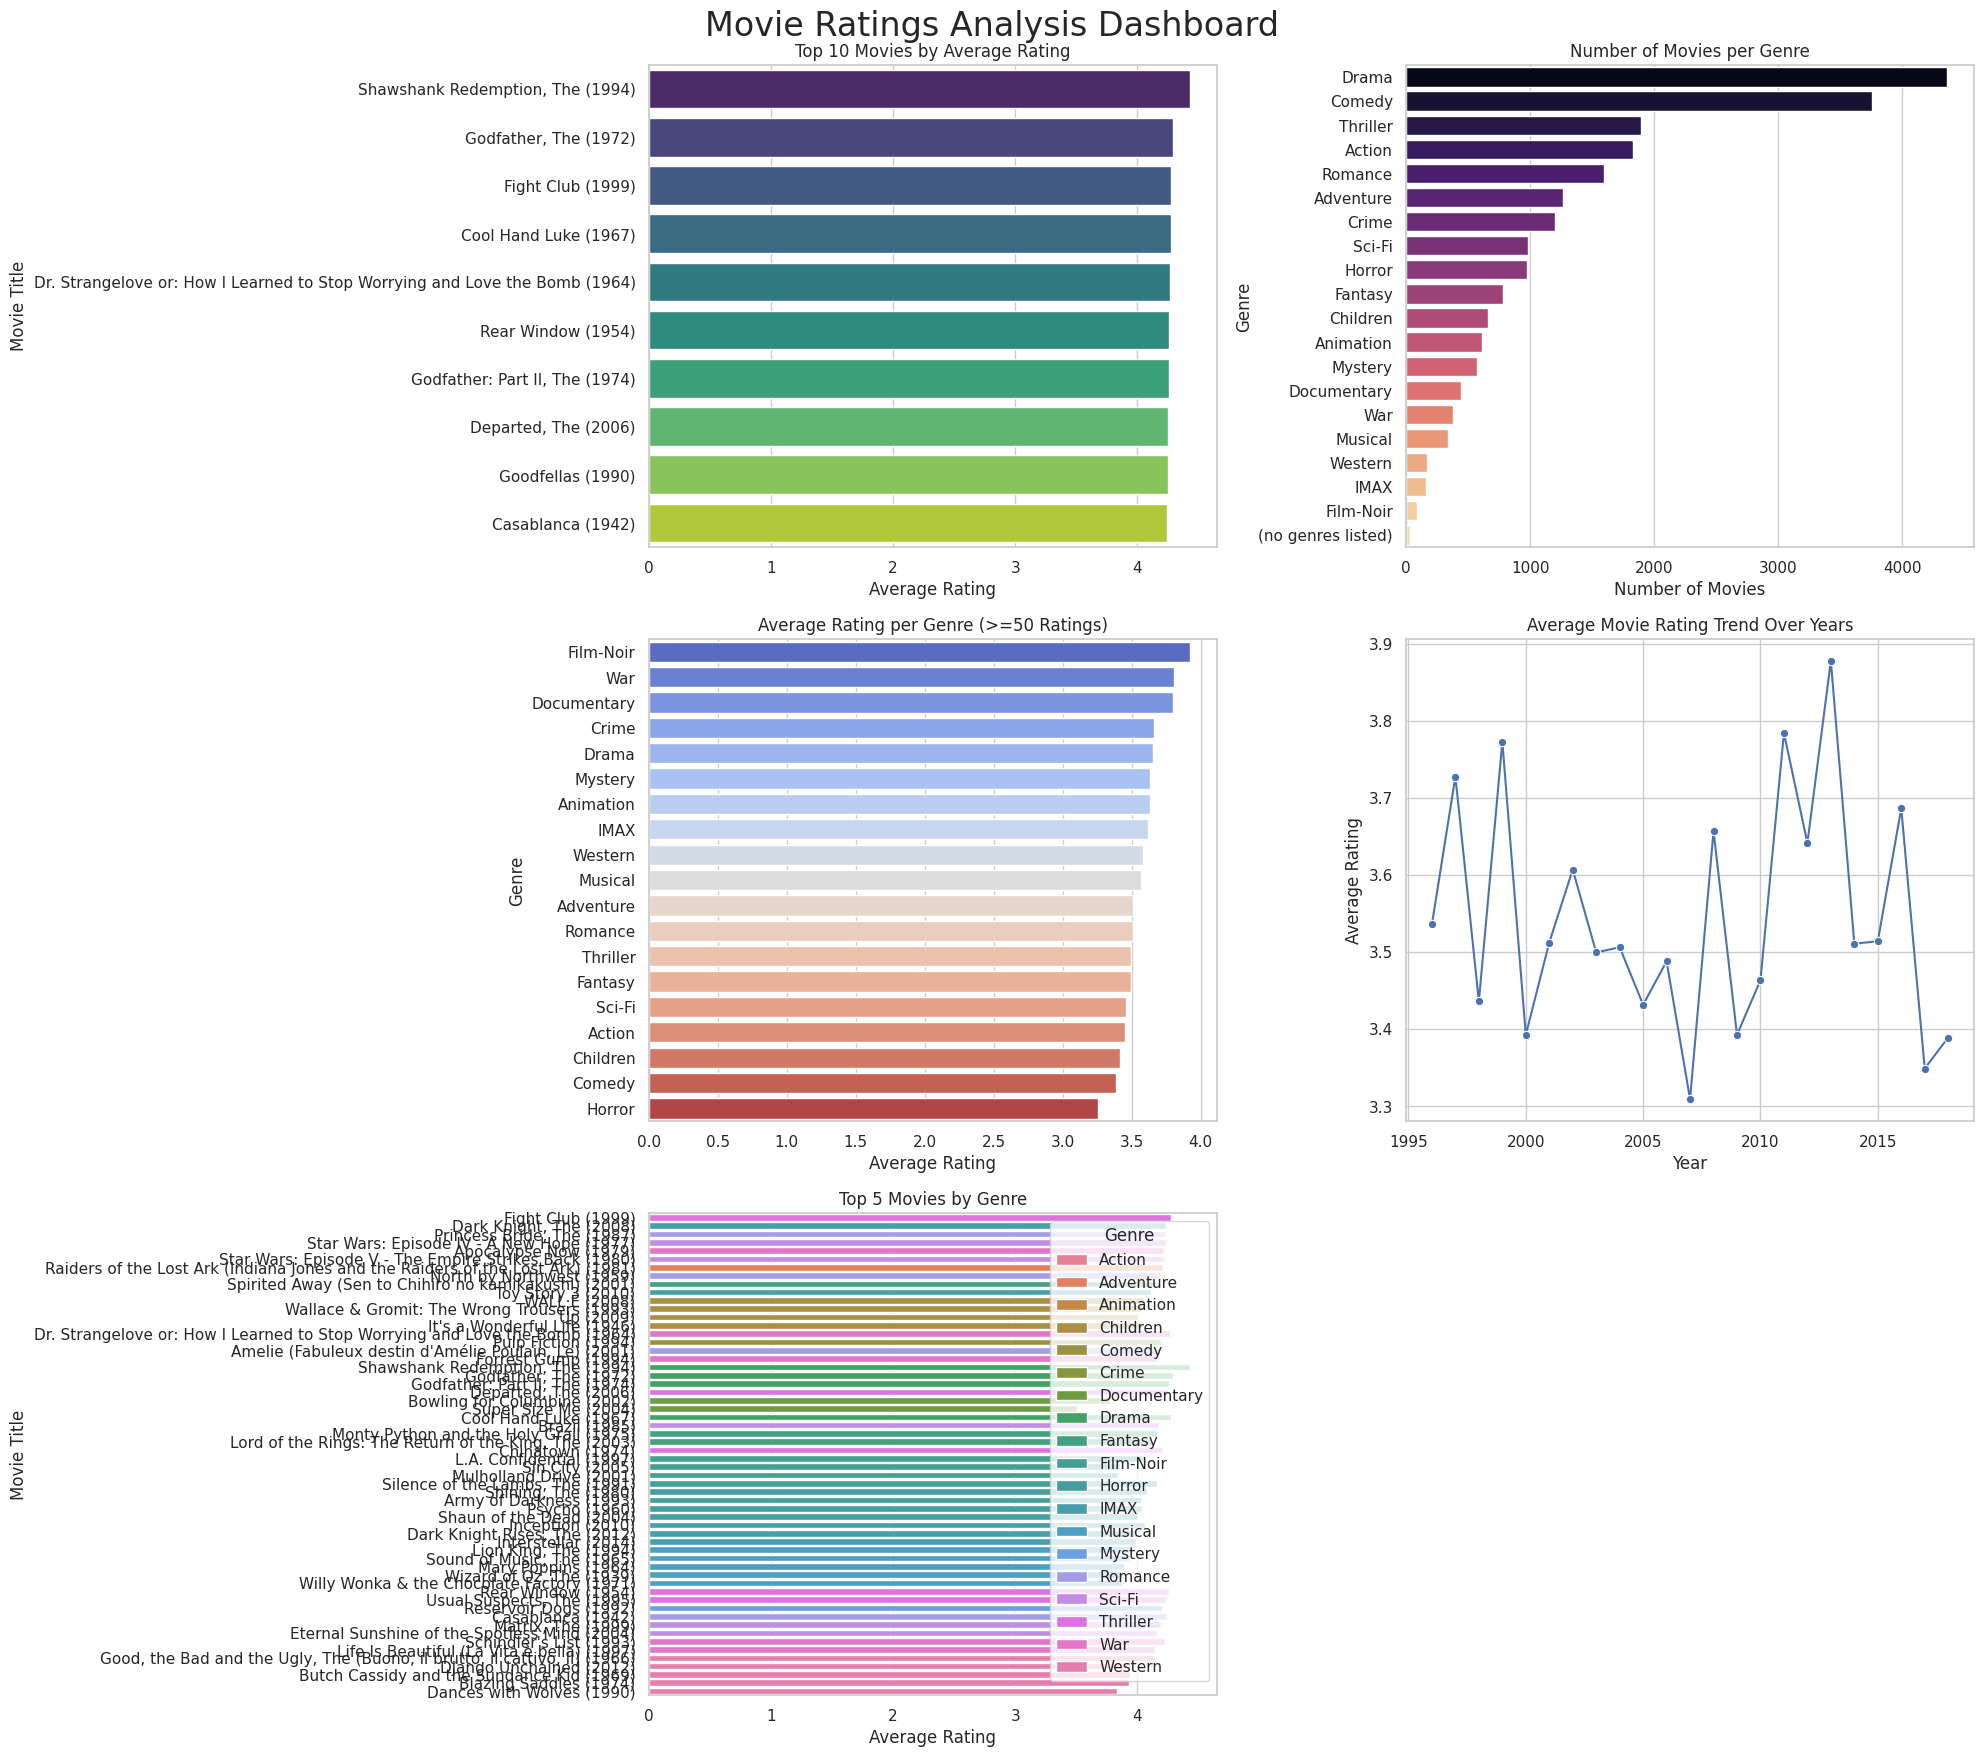

In [0]:
from pyspark.sql.functions import col, explode, split, from_unixtime, year, avg, count, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

# -----------------------------
# Load Workspace Tables
# -----------------------------
movies_df = spark.table("workspace.default.movies")
ratings_df = spark.table("workspace.default.ratings")

# -----------------------------
# Top-Rated Movies
# -----------------------------
movie_ratings_df = ratings_df.join(movies_df, on="movieId", how="inner")
top_movies_df = movie_ratings_df.groupBy("title") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("num_ratings")) \
    .filter(col("num_ratings") >= 50) \
    .orderBy(col("avg_rating").desc())
top_movies_pd = top_movies_df.toPandas().head(10)

# -----------------------------
# Most Popular Genres
# -----------------------------
movie_genres_df = movies_df.withColumn("genre", explode(split(col("genres"), r"\|")))
genre_count_df = movie_genres_df.groupBy("genre").count().orderBy(col("count").desc())
genre_count_pd = genre_count_df.toPandas()

# -----------------------------
# Average Rating per Genre
# -----------------------------
genre_ratings_df = ratings_df.join(movie_genres_df, on="movieId", how="inner")
avg_genre_rating_df = genre_ratings_df.groupBy("genre") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("num_ratings")) \
    .filter(col("num_ratings") >= 50) \
    .orderBy(col("avg_rating").desc())
avg_genre_rating_pd = avg_genre_rating_df.toPandas()

# -----------------------------
# Rating Trend Over Time
# -----------------------------
ratings_time_df = ratings_df.withColumn("year", year(from_unixtime(col("timestamp"))))
ratings_per_year_df = ratings_time_df.groupBy("year") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("num_ratings")) \
    .orderBy("year")
ratings_per_year_pd = ratings_per_year_df.toPandas()

# -----------------------------
# Top 5 Movies by Genre
# -----------------------------
genre_movie_ratings_df = ratings_df.join(movie_genres_df, on="movieId", how="inner")
genre_movie_avg_df = genre_movie_ratings_df.groupBy("genre", "title") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("num_ratings")) \
    .filter(col("num_ratings") >= 50)

windowSpec = Window.partitionBy("genre").orderBy(col("avg_rating").desc())
top5_movies_by_genre_df = genre_movie_avg_df.withColumn("rank", row_number().over(windowSpec)) \
    .filter(col("rank") <= 5) \
    .orderBy("genre", "rank")
top5_movies_by_genre_pd = top5_movies_by_genre_df.toPandas()

# -----------------------------
# Create Dashboard with Subplots
# -----------------------------
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Top 10 Movies
sns.barplot(x="avg_rating", y="title", data=top_movies_pd, palette="viridis", ax=axes[0,0])
axes[0,0].set_title("Top 10 Movies by Average Rating")
axes[0,0].set_xlabel("Average Rating")
axes[0,0].set_ylabel("Movie Title")

# Number of Movies per Genre
sns.barplot(x="count", y="genre", data=genre_count_pd, palette="magma", ax=axes[0,1])
axes[0,1].set_title("Number of Movies per Genre")
axes[0,1].set_xlabel("Number of Movies")
axes[0,1].set_ylabel("Genre")

# Average Rating per Genre
sns.barplot(x="avg_rating", y="genre", data=avg_genre_rating_pd, palette="coolwarm", ax=axes[1,0])
axes[1,0].set_title("Average Rating per Genre (>=50 Ratings)")
axes[1,0].set_xlabel("Average Rating")
axes[1,0].set_ylabel("Genre")

# Rating Trend Over Years
sns.lineplot(x="year", y="avg_rating", data=ratings_per_year_pd, marker="o", ax=axes[1,1])
axes[1,1].set_title("Average Movie Rating Trend Over Years")
axes[1,1].set_xlabel("Year")
axes[1,1].set_ylabel("Average Rating")

# Top 5 Movies per Genre
sns.barplot(x="avg_rating", y="title", hue="genre", data=top5_movies_by_genre_pd, dodge=False, ax=axes[2,0])
axes[2,0].set_title("Top 5 Movies by Genre")
axes[2,0].set_xlabel("Average Rating")
axes[2,0].set_ylabel("Movie Title")
axes[2,0].legend(title="Genre")

# Remove empty subplot
fig.delaxes(axes[2,1])

plt.suptitle("Movie Ratings Analysis Dashboard", fontsize=24)
plt.show()
